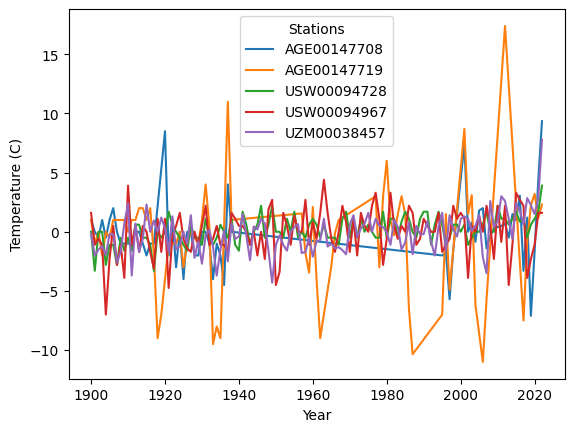

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import gzip as gz
import statistics as stat


# this was the test I did to figure out how to get pandas, jupyter notebook, and matplotlib to work
"""
df = pd.read_csv('C:\\Users\\mikeb\\Documents\\Stat129\\2022tiny.csv')
#print(df)
lines = df.plot.line(x='63', y='20220901')

plt.show
"""

df = pd.read_csv("out327put.csv", header=None) 
df.columns = ["year", "station", "tempInC"]
df["tempInC"] = df["tempInC"] / 10


"""df['temp_change'] = df['tempInC'] - df.groupby('station')['tempInC'].transform('median')
grouped = df.groupby('station')

# Plot the temperature for each station
for name, group in df:
    plt.plot(group['year'], group['temp_change'], label=name)
"""

station_median = df.groupby("station")["tempInC"].median()

# Subtract the median temperature from the temperature values for each station and year
df["temp_change"] = df.apply(lambda x: x["tempInC"] - station_median[x["station"]], axis=1)

grouped = df.groupby('station')

for name, group in grouped:
    plt.plot(group['year'], group['temp_change'], label=name)

plt.xlabel('Year')
plt.ylabel('Temperature (C)')
plt.legend(title="Stations")
plt.show()


![Time Of Parallel Program](tim327_.png)

> First thing I did was set up the Jupyter notebook in VS Code as a way of working backwards. I then built a shell script to run a bash pipeline that would end with a custom python script. To briefly summarize, the shell script reads off names of files and hands it to the command that runs a pipe in parallel. This parallel pipe searches the compressed files for the listed stations, which is then further refined to just pull the "TMAX" reading from those. The cut command then filters out the year, station name, and tmax reading in that order. 

> This is read into a python script that builds a dictionary with the stream. That dictionary is converted into a dataframe that is ultimately used to generate another dataframe of medians per sation of the chunk(the readings seperated into files grouped by years.) It then reads out the year, station name, and the tempurature median per station in that order. When ran in parallel each job sequentially stacks each reading making it easy to read into a .csv file(out327put.csv).

>Finally, I preformed the operations above to chart the data of out327put.csv in such a way that conforms to the isntructions. This involved converting it from tenths of celsius to celsius, as well as subtracting the median from the readings so as to essentially standardize the graphical read out of the line chart. My python script and zgrep appeard to be primary bottle necks, and would switch off throughout the process.

## tempPipe.sh
\#!/bin/bash

time ls /stat129/*.gz | parallel 'zgrep -E "AGE00147708|AGE00147719|UZM00038457|USW00094967|USW00094728" {} | zgrep "TMAX" | cut -d"," -f 1,2,4 | python3 tempTmax2Tavg.py'


## tempTmax2Tavg.py
wthrData={}

for line in sys.stdin:

        station, date, data = line.strip().split(',')
        dateYr = date[0:4]
        if station in wthrData:
            wthrData[station].append(float(data))
        else:
            wthrData[station] = [float(data)]

df = pd.DataFrame.from_dict(wthrData, orient='index')

df= pd.DataFrame.transpose(df)

dfmed = df.median()

for i, r in dfmed.items():

        print(dateYr+","+f"{i},{r}")